# Assignment 2 - Basic Machine Learning

Class: COMP 5600 - Artificial Intelligence

Author: Chris Hinkson

Email: cmh0201@auburn.edu


## Problem 1 Report

### Pre-Processing Decisions

I made several key decisions in the preprocessing steps for my models. In the Data Preparation and Processing block below, a utility class handles all of the needed data preparation. 

The first step in pre-processing the data was to find and fix null values. Specifically, I needed to find any values in any columns that were either NaN or just whitespace - essentially, any value that was meaningless. To do this, I took advantage of some Pandas utilities on dataframes, and was able to easily locate them. From there, for each feature, I simply selected one of two methods (default values or feature modes, both of which were given in the assignment instructions) at random and used the selected method to replace values. These were implemented very straightforward, and again, took advantage of dataframes to do them efficiently with Pandas.

The next step was handling the encoding of categorical features for the models. For this, I used OneHot Encoding, which is provided in scikit learn. Using this, I was able to turn all of the categorical features into numerical encodings, which seemed to have worked out fairly well based on model performance (see below).

The third step was doing the same process but for the target variable. Again, I used simple OneHot Encoding for this as well.

The fourth step was handling numerical features. These features actually ended up giving me several challenges throughout making my models, causing me to riddle out some quirks in how numpy and pandas were treating them. The first part of this was to ensure that the numerical values were being represented as floats so that they could be properly compared and operated on later in the models. The next part was normalizing the values, which I used the Normalizer from scikit learn to do. This prepared the three numerical features well for my models.

The fifth step, which I will admit may not totally be really pre-processing, but was needed between the other pre-processing steps and my models, was the splitting between features/values in the dataset. This allows for my models to have ready and convenient access to the different splits of data along with headers and other useful information.

### Performance Comparison

Both models were compared using statistics gained from 5-fold cross-validation. For the purposes of this report, I'll reference some instances below and compare them.

##### Logistic Regression
| CV Iteration   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|----------------|------------|-------------|----------|------------|-----------|
| 1              |    94.961  |           1 | 0.793003 |   0.884553 |  0.896501 |
| 2              |    95.1739 |           1 | 0.813187 |   0.89697  |  0.906593 |
| 3              |    93.6125 |           1 | 0.767442 |   0.868421 |  0.883721 |
| 4              |    93.892  |           1 | 0.784461 |   0.879213 |  0.892231 |
| 5              |    94.6023 |           1 | 0.797872 |   0.887574 |  0.898936 |
| Average        |    94.4483 |           1 | 0.791193 |   0.883346 |  0.895597 |

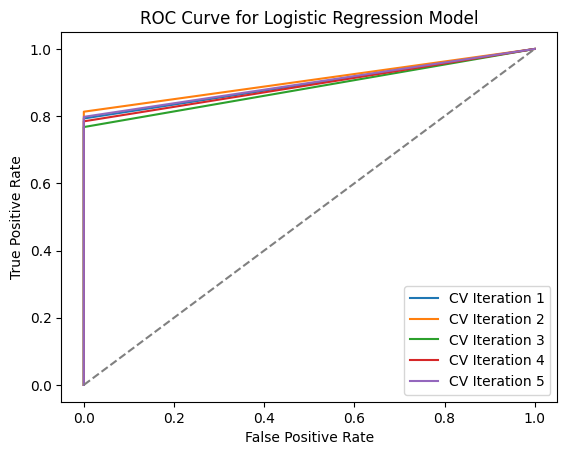

##### Naive Bayes
| CV Iteration   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|----------------|------------|-------------|----------|------------|-----------|
| 1              |    64.5138 |    0.396026 | 0.87172  |   0.544627 |  0.721976 |
| 2              |    67.0688 |    0.433687 | 0.898352 |   0.584973 |  0.74487  |
| 3              |    66.1462 |    0.440476 | 0.860465 |   0.582677 |  0.723285 |
| 4              |    65.625  |    0.444877 | 0.859649 |   0.586325 |  0.717733 |
| 5              |    68.679  |    0.455172 | 0.87766  |   0.599455 |  0.747454 |
| Average        |    66.4066 |    0.434048 | 0.873569 |   0.579611 |  0.731064 |

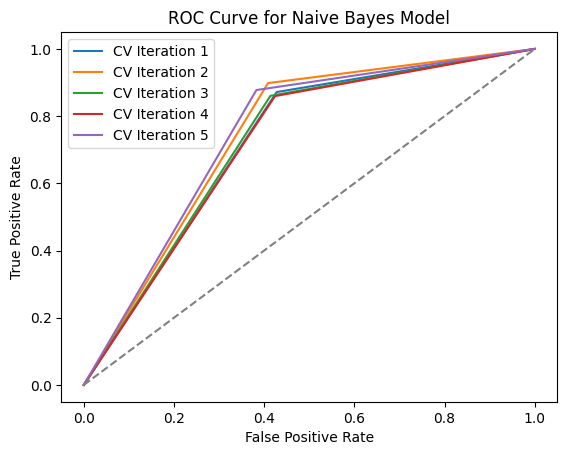

##### Comparison

As shown, both models did somewhat okay with the data. However, to me there is a clear winner by logistic regression based on these results. Logistic regression achieved better across most categories. It had great accuracy and precision, decent recall, high F1, and high ROC AUC. Naive Bayes didn't perform too bad, but it was significantly less than Logistic Regression. Based on the disparity between the two models, I would say that Logistic Regression is the better model for the data set.

### Insights Gained

I gained a lot of valuable insights and experience from this portion of the project. On the surface, being the first time that I have implemented either of these algorithms from scratch, it was a big challenge filled with tons of mistakes. I had to force myself to break each part of each model down to the building blocks and bridge between my conceptual understanding of what is going on with what my code needs to do to accomplish that. While I could make an endless list, here is some insight I gained from assignment:
- There are a lot of ways to accomplish individual tasks within the program. Understanding what numpy and pandas are doing was a great help in understanding not just why something would work but why something else would also not work. Conceptually going from X->Y is fairly easy, but when you are limited to the data types and operations provided, you must become clever at accomplishing that *efficiently* in your code. The same is scaled up for scikit: this project made it much more clear what is going on under-the-hood when we call our fancy functions from libraries. Sci-kit normally handles a lot of this stuff for us, so creating them in scratch was a fun challenge to address problems I wouldn't have otherwise considered.
- The different formulas, especially when it comes to probability formulas, can get very confusing fast. Following along in a tutorial or even the lectures (no offense at all, complete respect to Dr. Aakur, his lectures are some of the best) can only get you so far. Sometimes, you need to actually go through and do it - figure out what formulas you need, what all is going into them, how to get all of those inputs, and how to use the output of the formulas, in order to truly understand why we need them. A big way that I think this was revealed was when using dummy functions for equations; for instance, to skip past coding a formula, simply putting a `return 0` and seeing how the model bricks. Seeing how the equations when done right and wrong was an important step for me in exploring how the models work and why each formula serves its purpose.

Overall, this was a great assignment, and I would find more like it fun! I learned a lot :)

In [35]:
### MODULE IMPORTS ###
import os
import cv2
import time
import math
import random
import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc

### DEVELOPER OPTIONS ###

# Whether to print pre-processing information at runtime
DFLAG_PRINT_PREPROCESSING = True
DFLAG_PRINT_KMEANSINFO = True

# Enforce Pandas 3.0 Copy-On-Write
pd.options.mode.copy_on_write = True


In [138]:
'''
DATA PREPARATION AND PROCESSING

This block will handle the data preparation and processing for the churn prediction task.
'''

# Creation of utility class to handle data preparation
class ChurnUtilities:

	# Class Constructor
	def __init__(self, dataSetFileName):

		# Save dataset file
		self.dataSetFileName = dataSetFileName

		# Load the raw dataset using Pandas and make copy for pre-processing
		self.dataSet = pd.read_csv(self.dataSetFileName)

		# Create default values (I assume that this is what was meant in the assignment instructions)
		self.defaultValues = {
			"customerID": "0000-LVOTP", # loveliest village on the plains :)
			"gender": "Male",
			"SeniorCitizen": 0,
			"Partner": "No",
			"Dependents": "No",
			"tenure": 0,
			"PhoneService": "No",
			"MultipleLines": "No phone service",
			"InternetService": "No",
			"OnlineSecurity": "No internet service",
			"OnlineBackup": "No internet service",
			"DeviceProtection": "No internet service",
			"TechSupport": "No internet service",
			"StreamingTV": "No internet service",
			"StreamingMovies": "No internet service",
			"Contract": "Month-to-month",
			"PaperlessBilling": "No",
			"PaymentMethod": "Electronic check",
			"MonthlyCharges": 0.0,
			"TotalCharges": 0.0,
			"Churn": "No"
		}

		# Create hard list for features and target variable
		self.featuresList = ["gender", "SeniorCitizen", "Partner", "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges"]
		self.featuresList_categorical = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]
		self.targetVariable = "Churn"

		######################################################
		# Data Pre-Processing Step One: Handling Null Values #
		######################################################
		for colName in self.dataSet.columns:

			# Check if the column has any null (or empty) values
			self.dataSet.replace(to_replace=r'^\s*$', value=np.nan, regex=True, inplace=True)
			numberNullValues = self.dataSet[colName].isnull().sum()
			if numberNullValues == 0:
				self.__print(f"The feature {colName} has no null values!")
				continue

			# Select a random method for handling null values
			methods = ["Feature Mode", "Feature Default"]
			replacementMethod = random.choice(methods)
			if replacementMethod == "Feature Mode":
				# The replacement value will be the most common value in the column (or the first mode if there are multiple)
				replacementValue = self.dataSet[colName].mode()[0]
			elif replacementMethod == "Feature Default":
				# The replacement value will be a pre-determined default value
				replacementValue = self.defaultValues[colName]
			else:
				raise Exception(f"Error: Attempted to select replacement method for feature {colName}, but {replacementMethod} is not valid!")

			# Replace the null values with the replacement value
			self.dataSet.fillna({colName: replacementValue}, inplace=True)
			self.__print(f"The feature {colName} had {numberNullValues} null values replaced with '{replacementValue}' via the {replacementMethod} method!")

		###############################################################
		# Data Pre-Processing Step Two: Handling Categorical Features #
		###############################################################

		# Create One-Hot Encoder with scikit-learn and encode all categorical features
		dataEncoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
		encodedDataSet = dataEncoder.fit_transform(self.dataSet[self.featuresList_categorical])

		# Fix original data set with encoded features
		self.dataSet.drop(columns=self.featuresList_categorical, inplace=True)
		self.dataSet = pd.concat([self.dataSet, encodedDataSet], axis=1)

		############################################################
		# Data Pre-Processing Step Three: Handling Target Variable #
		############################################################

		# Create One-Hot Encoder with scikit-learn and encode the target variable
		targetEncoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
		encodedTargetSet = targetEncoder.fit_transform(self.dataSet[self.targetVariable].to_frame())

		self.dataSet.drop(columns=self.targetVariable, inplace=True)
		self.dataSet = pd.concat([self.dataSet, encodedTargetSet], axis=1)

		##############################################################
		# Data Pre-Processing Step Four: Handling Numerical Features #
		##############################################################

		# Convert numerical features to float type
		self.dataSet['tenure'] = self.dataSet['tenure'].astype(float)
		self.dataSet['MonthlyCharges'] = self.dataSet['MonthlyCharges'].astype(float)
		self.dataSet['TotalCharges'] = self.dataSet['TotalCharges'].astype(float)

		# Normalize numerical features
		NumericalNormalizer = Normalizer().set_output(transform="pandas")
		normalizedNumericalFeatures = NumericalNormalizer.fit_transform(self.dataSet[['tenure', 'MonthlyCharges', 'TotalCharges']])
		self.dataSet.drop(columns=['tenure', 'MonthlyCharges', 'TotalCharges'], inplace=True)
		self.dataSet = pd.concat([self.dataSet, normalizedNumericalFeatures], axis=1)

		##############################################################
		# Data Pre-Processing Step Five: Splitting Features / Target #
		##############################################################
		self.featuresList = [col for col in self.dataSet.columns if col != self.targetVariable and col != "customerID"]
		self.targetVariable = encodedTargetSet.columns[0]
		self.features = self.dataSet[self.featuresList]
		self.target = self.dataSet[self.targetVariable]
		self.dataSet.set_index('customerID', drop=True, inplace=True)
	
	# Printing Utility Function (private method, used to enable developer setting)
	def __print(self, message):
		if DFLAG_PRINT_PREPROCESSING:
			print(message)
	
# Creation of utility class to handle results comparison and processing
class ChurnResultsUtilities:

	# Class Constructor
	def __init__(self):
		# Initialize a dictionary to hold the results for each model
		self.PredictionsDict = {}
		self.AccuracyDict = {}
		self.PrecisionDict = {}
		self.RecallDict = {}
		self.F1Dict = {}
		self.ROCAUCDict = {}
		self.falsePositiveRateDict = {}
		self.truePositiveRateDict = {}

	################################
	# RECORDERS FOR SAVING RESULTS #
	################################
	def recordPredictions(self, modelName, cvIteration, predictions):
		if modelName not in self.PredictionsDict:
			self.PredictionsDict[modelName] = {}
		self.PredictionsDict[modelName][cvIteration] = predictions

	def recordModelStatistics(self, modelName, cvIteration, accuracy, precision, recall, f1Score, roc_auc, falsePositiveRate, truePositiveRate):
		if modelName not in self.AccuracyDict:
			self.AccuracyDict[modelName] = {}
		self.AccuracyDict[modelName][cvIteration] = accuracy

		if modelName not in self.PrecisionDict:
			self.PrecisionDict[modelName] = {}
		self.PrecisionDict[modelName][cvIteration] = precision

		if modelName not in self.RecallDict:
			self.RecallDict[modelName] = {}
		self.RecallDict[modelName][cvIteration] = recall

		if modelName not in self.F1Dict:
			self.F1Dict[modelName] = {}
		self.F1Dict[modelName][cvIteration] = f1Score

		if modelName not in self.ROCAUCDict:
			self.ROCAUCDict[modelName] = {}
		self.ROCAUCDict[modelName][cvIteration] = roc_auc

		if modelName not in self.falsePositiveRateDict:
			self.falsePositiveRateDict[modelName] = {}
		self.falsePositiveRateDict[modelName][cvIteration] = falsePositiveRate

		if modelName not in self.truePositiveRateDict:
			self.truePositiveRateDict[modelName] = {}
		self.truePositiveRateDict[modelName][cvIteration] = truePositiveRate

	def getAverageModelStatistics(self, modelName):
		# Calculate averages for each statistic
		accuracy = sum(self.AccuracyDict[modelName].values()) / len(self.AccuracyDict[modelName])
		precision = sum(self.PrecisionDict[modelName].values()) / len(self.PrecisionDict[modelName])
		recall = sum(self.RecallDict[modelName].values()) / len(self.RecallDict[modelName])
		f1Score = sum(self.F1Dict[modelName].values()) / len(self.F1Dict[modelName])
		roc_auc = sum(self.ROCAUCDict[modelName].values()) / len(self.ROCAUCDict[modelName])
		falsePositiveRate = sum(self.falsePositiveRateDict[modelName].values()) / len(self.falsePositiveRateDict[modelName])
		truePositiveRate = sum(self.truePositiveRateDict[modelName].values()) / len(self.truePositiveRateDict[modelName])
		return accuracy, precision, recall, f1Score, roc_auc, falsePositiveRate, truePositiveRate

	############################################
	# UTILITY FUNCTIONS FOR RESULTS PROCESSING #
	############################################
	def getPredictionAccuracy(self, realValues, predictedValues):
		correctPredictions = sum(realValues == predictedValues)
		totalPredictions = len(realValues)
		return ((correctPredictions / totalPredictions) * 100)
	
	def getPredictionPrecision(self, realValues, predictedValues):
		truePositives = sum((realValues == 1) & (predictedValues == 1))
		falsePositives = sum((realValues == 0) & (predictedValues == 1))
		return truePositives / (truePositives + falsePositives)
	
	def getPredictionRecall(self, realValues, predictedValues):
		truePositives = sum((realValues == 1) & (predictedValues == 1))
		falseNegatives = sum((realValues == 1) & (predictedValues == 0))
		return truePositives / (truePositives + falseNegatives)
	
	def getPredictionF1Score(self, precision, recall):
		return (2 * precision * recall) / (precision + recall)
	
	def getROCAUC(self, realValues, predictedValues):
		falsePositiveRate, truePositiveRate, thresholds = roc_curve(realValues, predictedValues)
		roc_auc = auc(falsePositiveRate, truePositiveRate)
		return roc_auc, falsePositiveRate, truePositiveRate, thresholds

# Build churn object with dataset
TelcoChurnUtilities = ChurnUtilities("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Build results object
TelcoResultsUtilities = ChurnResultsUtilities()

The feature customerID has no null values!
The feature gender has no null values!
The feature SeniorCitizen has no null values!
The feature Partner has no null values!
The feature Dependents has no null values!
The feature tenure has no null values!
The feature PhoneService has no null values!
The feature MultipleLines has no null values!
The feature InternetService has no null values!
The feature OnlineSecurity has no null values!
The feature OnlineBackup has no null values!
The feature DeviceProtection has no null values!
The feature TechSupport has no null values!
The feature StreamingTV has no null values!
The feature StreamingMovies has no null values!
The feature Contract has no null values!
The feature PaperlessBilling has no null values!
The feature PaymentMethod has no null values!
The feature MonthlyCharges has no null values!
The feature TotalCharges had 11 null values replaced with '20.2' via the Feature Mode method!
The feature Churn has no null values!


Performing 5-Fold Cross-Validation for Logistic Regression Model

| CV Iteration   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|----------------|------------|-------------|----------|------------|-----------|
| 1              |    94.961  |           1 | 0.793003 |   0.884553 |  0.896501 |
| 2              |    95.1739 |           1 | 0.813187 |   0.89697  |  0.906593 |
| 3              |    93.6125 |           1 | 0.767442 |   0.868421 |  0.883721 |
| 4              |    93.892  |           1 | 0.784461 |   0.879213 |  0.892231 |
| 5              |    94.6023 |           1 | 0.797872 |   0.887574 |  0.898936 |
| Average        |    94.4483 |           1 | 0.791193 |   0.883346 |  0.895597 |


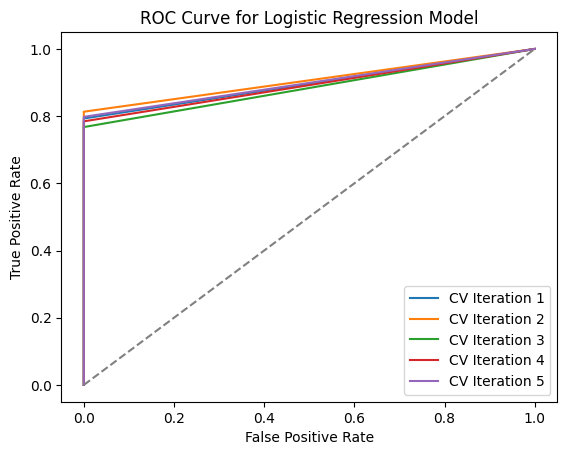

In [ ]:
'''
LOGISTIC REGRESSION MODEL

This block will build a logistic regression model on a given dataset.

Basic Assumptions Taken:
- The dataset has been pre-processed (see previous code blocks)
- The target variable is binary classification such that there are only two possible values
'''

# Creation of model class for logistic regression
class LogisticRegressionModel:

	# Class Constructor
	def __init__(self, learningRate=0.01, iterations=1000):
		self.learningRate = learningRate
		self.iterations = iterations
		self.weights = None
		self.bias = None
		self.iterationLoss = []

	# Calculate sigmoid logistic function g(z)
	def __calculateSigmoid(self, x):
		return (1 / (1 + np.exp(-x)))
	
	# Calculate log likelihood function
	def __calculateLogLikelihood(self, yPredicted, yActual):
		return -np.mean((yActual * np.log(yPredicted)) + ((1 - yActual) * np.log(1 - yPredicted)))

	# Fit model to a given data set
	def trainModel(self, featureSet, targetSet):

		# Initialize the weights and bias (all to 0)
		self.weights = np.zeros(featureSet.shape[1])
		self.bias = 0
		
		# Perform gradient descent for the specified number of iterations
		for i in range(self.iterations):
			
			# Make predictions using the sigmoid function
			weightedValues = np.dot(featureSet, self.weights) + self.bias
			predictedValues = self.__calculateSigmoid(weightedValues)

			# Get differences from predictions
			difference = predictedValues - targetSet

			# Compute updates
			self.weights -= self.learningRate * (1 / featureSet.shape[0]) * np.dot(featureSet.T, difference)
			self.bias -= self.learningRate * (1 / featureSet.shape[0]) * np.sum(difference)

			# Track log likelihood loss for each iteration
			self.iterationLoss.append(self.__calculateLogLikelihood(predictedValues, targetSet))
	
	# Make prediction for a given sample
	def predict(self, sample):
		# Calculate the weighted value by dotting data x weights and adding bias
		weightedValues = np.dot(sample, self.weights) + self.bias

		# Since this is binary classification, return 1 if sigmoid is greater than 0.5, else return 0
		return (self.__calculateSigmoid(weightedValues) >= 0.5).astype(int)
		


X_train, X_test, y_train, y_test = train_test_split(TelcoChurnUtilities.features, TelcoChurnUtilities.target, test_size=0.2, random_state=42)
regressor = LogisticRegressionModel()
regressor.trainModel(X_train, y_train)
predictions = regressor.predict(X_test)

# Perform 5-Fold Cross-Validation
print(f"Performing 5-Fold Cross-Validation for Logistic Regression Model\n")
kFoldGenerator = KFold(n_splits=5, shuffle=True, random_state=2002)
for iteration, (trainIndices, testIndices) in enumerate(kFoldGenerator.split(TelcoChurnUtilities.dataSet)):
	# Split the data into training and testing sets
	trainSetFeatures = TelcoChurnUtilities.features.iloc[trainIndices]
	trainSetTarget = TelcoChurnUtilities.target.iloc[trainIndices]
	testSetFeatures = TelcoChurnUtilities.features.iloc[testIndices]
	testSetTarget = TelcoChurnUtilities.target.iloc[testIndices]

	# Train the model on the training set
	IterationLogisticRegressionModel = LogisticRegressionModel()
	IterationLogisticRegressionModel.trainModel(trainSetFeatures, trainSetTarget)

	# Make predictions on the test set
	predictions = IterationLogisticRegressionModel.predict(testSetFeatures)
	TelcoResultsUtilities.recordPredictions("Logistic Regression", iteration, predictions)

	# Calculate accuracy, precision, recall, F1 score, and ROCAUC
	accuracy = TelcoResultsUtilities.getPredictionAccuracy(testSetTarget, predictions)
	precision = TelcoResultsUtilities.getPredictionPrecision(testSetTarget, predictions)
	recall = TelcoResultsUtilities.getPredictionRecall(testSetTarget, predictions)
	f1Score = TelcoResultsUtilities.getPredictionF1Score(precision, recall)
	roc_auc, falsePositiveRate, truePositiveRate, thresholds = TelcoResultsUtilities.getROCAUC(testSetTarget, predictions)

	# Record the model statistics
	TelcoResultsUtilities.recordModelStatistics("Logistic Regression", iteration, accuracy, precision, recall, f1Score, roc_auc, falsePositiveRate, truePositiveRate)

# Display results for Logistic Regression model
LogisticRegressionResults_Header = ["CV Iteration", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
LogisticRegressionResults_Table = []
for i in range(5):
	# Get the results for each iteration
	accuracy = TelcoResultsUtilities.AccuracyDict["Logistic Regression"][i]
	precision = TelcoResultsUtilities.PrecisionDict["Logistic Regression"][i]
	recall = TelcoResultsUtilities.RecallDict["Logistic Regression"][i]
	f1Score = TelcoResultsUtilities.F1Dict["Logistic Regression"][i]
	roc_auc = TelcoResultsUtilities.ROCAUCDict["Logistic Regression"][i]
	truePositiveRate = TelcoResultsUtilities.truePositiveRateDict["Logistic Regression"][i]
	falsePositiveRate = TelcoResultsUtilities.falsePositiveRateDict["Logistic Regression"][i]

	# Plot ROC curve for the iteration
	plt.plot(falsePositiveRate, truePositiveRate, label=f"CV Iteration {i+1}")

	# Append the results to the table
	LogisticRegressionResults_Table.append([(i+1), accuracy, precision, recall, f1Score, roc_auc])

# Get average statistics for Logistic Regression model
avgAccuracy, avgPrecision, avgRecall, avgF1Score, avgROCAUC, avgFalsePositiveRate, avgTruePositiveRate = TelcoResultsUtilities.getAverageModelStatistics("Logistic Regression")
LogisticRegressionResults_Table.append(["Average", avgAccuracy, avgPrecision, avgRecall, avgF1Score, avgROCAUC])

# Display the results table
print(tabulate.tabulate(LogisticRegressionResults_Table, headers=LogisticRegressionResults_Header, tablefmt='github'))

# Display ROC curve for the cv iterations
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend()
plt.show()


Performing 5-Fold Cross-Validation for Naive Bayes Model

| CV Iteration   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|----------------|------------|-------------|----------|------------|-----------|
| 1              |    64.5138 |    0.396026 | 0.87172  |   0.544627 |  0.721976 |
| 2              |    67.0688 |    0.433687 | 0.898352 |   0.584973 |  0.74487  |
| 3              |    66.1462 |    0.440476 | 0.860465 |   0.582677 |  0.723285 |
| 4              |    65.625  |    0.444877 | 0.859649 |   0.586325 |  0.717733 |
| 5              |    68.679  |    0.455172 | 0.87766  |   0.599455 |  0.747454 |
| Average        |    66.4066 |    0.434048 | 0.873569 |   0.579611 |  0.731064 |


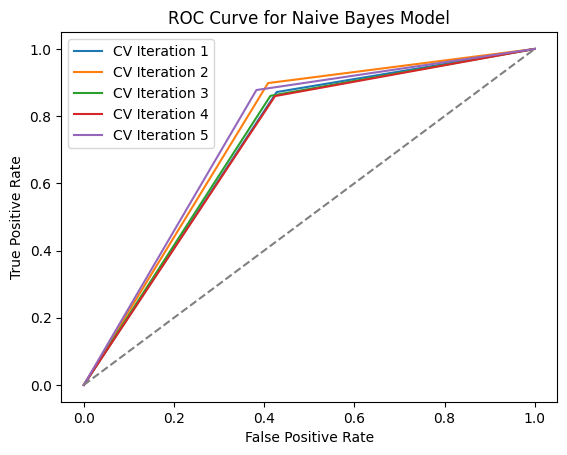

In [ ]:
'''
NAIVE BAYES MODEL

This block will build a naive bayes model on a given dataset.

Basic Assumptions Taken:
- The dataset has been pre-processed (see previous code blocks)
- The target variable is binary classification such that there are only two possible values
'''

# Creation of model class for naive bayes
class NaiveBayesModel:

	# Class Constructor
	def __init__(self):
		self.targetVariable = None
		self.targetClasses = {}
		self.targetClassMeans = {}
		self.targetClassStdDevs = {}
		self.targetClassGaussianProbabilities = {}

	# Fit model to a given data set
	def trainModel(self, dataSet, targetVariableName):
		# Store the target variable name
		self.targetVariable = targetVariableName

		# Get all unique target classes from the dataset
		for targetClass in dataSet[targetVariableName].unique():
			# Store the records for the target class
			self.targetClasses[targetClass] = dataSet[dataSet[targetVariableName].isin([targetClass])]
			self.targetClasses[targetClass].drop(columns=targetVariableName, inplace=True)

			# Calculate the mean and standard deviation for each feature in each target class
			self.targetClassMeans[targetClass] = self.targetClasses[targetClass].mean()
			self.targetClassStdDevs[targetClass] = self.targetClasses[targetClass].std()

	# Calculate the prior probability for a given target class
	def __calculatePriorProbability(self, targetClass):
		return len(self.targetClasses[targetClass]) / len(self.targetClasses)
	
	# Calculate the Gaussian probability for a given value, mean, and std dev
	def __calculateGaussianProbability(self, x, mean, stdDev):
		return ((1 / (math.sqrt(2 * math.pi) * stdDev)) * math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdDev, 2)))))

	# Calculate the Gaussian probability for a given value, feature, and target class (wrapper for above)
	def __calculateGaussianProbabilityForClassFeature(self, x, feature, targetClass):
		mean = self.targetClassMeans[targetClass][feature]
		stdDev = self.targetClassStdDevs[targetClass][feature]
		return self.__calculateGaussianProbability(x, mean, stdDev)

	# Calculate the probability for a given sample (panda series) belonging to a target class
	def calculateClassProbabilitiesForSample(self, sample):
		# Check if the sample still has the target variable
		if self.targetVariable in sample.index:
			sample.drop(self.targetVariable, inplace=True)

		# Initialize a dictionary to hold the probabilities for each target class
		classProbabilitiesForSample = {}
		
		# Get the prior probability for the target class
		for targetClass in self.targetClasses.keys():
			# Get the prior probability for the target class
			classProbabilitiesForSample[targetClass] = self.__calculatePriorProbability(targetClass)

			# Loop through each feature in the sample and calculate the Gaussian probability
			for feature in sample.index:
				classProbabilitiesForSample[targetClass] *= self.__calculateGaussianProbabilityForClassFeature(sample[feature], feature, targetClass)

		# Return the class probabilities for the sample
		return classProbabilitiesForSample

	# Get the most probable target class for a given sample
	def predictTargetClassForSample(self, sample):
		classProbabilitiesForSample = self.calculateClassProbabilitiesForSample(sample)
		mostProbableTargetClass = max(classProbabilitiesForSample, key=classProbabilitiesForSample.get)
		return mostProbableTargetClass
	
	# Batch predict target classes for a given set of samples
	def predict(self, samples):
		return samples.apply(func=self.predictTargetClassForSample, axis=1)

# Perform 5-Fold Cross-Validation
print(f"Performing 5-Fold Cross-Validation for Naive Bayes Model\n")
kFoldGenerator = KFold(n_splits=5, shuffle=True, random_state=2002)
for iteration, (trainIndices, testIndices) in enumerate(kFoldGenerator.split(TelcoChurnUtilities.dataSet)):
	# Split the data into training and testing sets
	trainSet = TelcoChurnUtilities.dataSet.iloc[trainIndices]
	testSet = TelcoChurnUtilities.dataSet.iloc[testIndices]

	# Train the model on the training set
	IterationBayesModel = NaiveBayesModel()
	IterationBayesModel.trainModel(trainSet, TelcoChurnUtilities.targetVariable)

	# Make predictions on the test set
	predictions = IterationBayesModel.predict(testSet)
	TelcoResultsUtilities.recordPredictions("Naive Bayes", iteration, predictions)

	# Calculate accuracy, precision, recall, F1 score, and ROCAUC
	accuracy = TelcoResultsUtilities.getPredictionAccuracy(testSet[TelcoChurnUtilities.targetVariable], predictions)
	precision = TelcoResultsUtilities.getPredictionPrecision(testSet[TelcoChurnUtilities.targetVariable], predictions)
	recall = TelcoResultsUtilities.getPredictionRecall(testSet[TelcoChurnUtilities.targetVariable], predictions)
	f1Score = TelcoResultsUtilities.getPredictionF1Score(precision, recall)
	roc_auc, falsePositiveRate, truePositiveRate, thresholds = TelcoResultsUtilities.getROCAUC(testSet[TelcoChurnUtilities.targetVariable], predictions)

	# Record the model statistics
	TelcoResultsUtilities.recordModelStatistics("Naive Bayes", iteration, accuracy, precision, recall, f1Score, roc_auc, falsePositiveRate, truePositiveRate)

# Display results for Naive Bayes model
NaiveBayesResults_Header = ["CV Iteration", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
NaiveBayesResults_Table = []
for i in range(5):
	# Get the results for each iteration
	accuracy = TelcoResultsUtilities.AccuracyDict["Naive Bayes"][i]
	precision = TelcoResultsUtilities.PrecisionDict["Naive Bayes"][i]
	recall = TelcoResultsUtilities.RecallDict["Naive Bayes"][i]
	f1Score = TelcoResultsUtilities.F1Dict["Naive Bayes"][i]
	roc_auc = TelcoResultsUtilities.ROCAUCDict["Naive Bayes"][i]
	truePositiveRate = TelcoResultsUtilities.truePositiveRateDict["Naive Bayes"][i]
	falsePositiveRate = TelcoResultsUtilities.falsePositiveRateDict["Naive Bayes"][i]

	# Plot ROC curve for the iteration
	plt.plot(falsePositiveRate, truePositiveRate, label=f"CV Iteration {i+1}")

	# Append the results to the table
	NaiveBayesResults_Table.append([(i+1), accuracy, precision, recall, f1Score, roc_auc])

# Get average statistics for Naive Bayes model
avgAccuracy, avgPrecision, avgRecall, avgF1Score, avgROCAUC, avgFalsePositiveRate, avgTruePositiveRate = TelcoResultsUtilities.getAverageModelStatistics("Naive Bayes")
NaiveBayesResults_Table.append(["Average", avgAccuracy, avgPrecision, avgRecall, avgF1Score, avgROCAUC])

# Display the results table
print(tabulate.tabulate(NaiveBayesResults_Table, headers=NaiveBayesResults_Header, tablefmt='github'))

# Display ROC curve for the cv iterations
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Model')
plt.legend()
plt.show()

## Problem 2 Report

### Implementation Decisions
My implementation of K-means is very straightforward. As described in the assignment directions, we want to converge the color values to find the top-k common colors. At each iteration step in the algorithm, I find which of the cluster colors are closest to each pixel's color, and add that pixel color value to the cluster's list. I then compute new cluster colors by taking the average over all of the pixel colors that are in the list for that iteration. This allows the colors to converge until they are within a threshold of change or reach the maximum iterations allowed.

To actually implement the algorithm, I used a variety of data types and strategies. For storing data, I primary used python lists, python dictionaries, and numpy arrays. Python lists and dictionaries allowed me to have easy lookups and additions, and numpy arrays made computing things like means much easier. For distances between color values, I used np.linalg.norm with a default norm value of 2, which is the L2 norm / Euclidean distance. It is possible that perhaps other distance measures would result in better or worse compression results, but I personally like Euclidean so I stuck with that. 

### K Value Comparison

To get some performance metrics on the different values of k, I looked at both time, file size, and visual quality. For the time, I simply recorded the total amount of time that it took the algorithm to run for each k value while giving it up to 100 max iterations. For the file size, I compared the difference in bytes between the file size of the original image and the newly compressed image for each k value. Finally, for the visual quality, I simply checked each of the resulting images and compared them to the original image.

To display the metric results (time and file size), I created a table and graph:
|   K Value |   Time (s) |   File Size Difference (bytes) |
|-----------|------------|--------------------------------|
|         5 |    5.00582 |                          25027 |
|        10 |   18.1327  |                          20079 |
|        20 |   69.3805  |                          15890 |
|        50 |  169.968   |                           8354 |
|       100 |  336.454   |                           4283 |

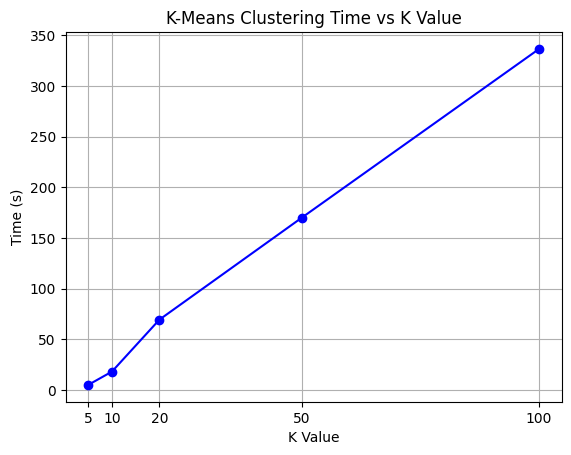
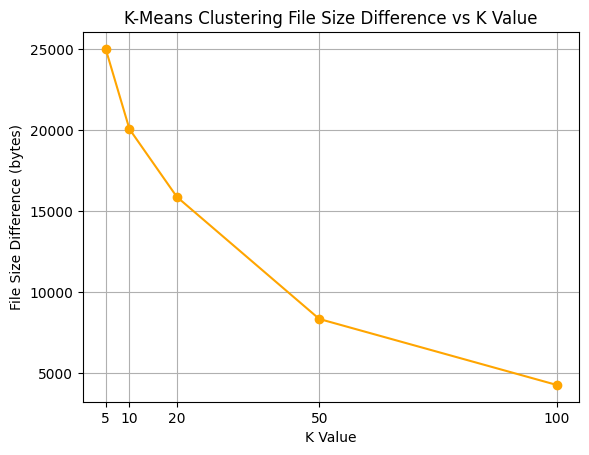

From these metrics alone, the trend of the algorithm performance is the same as expected: the higher the k value, the longer it takes to run, and the less compressed the result is (lesser file size difference). The time of the algorithms appears to follow a mostly linear path, whereas the file size difference appears to follow an exponential decay (ish) path. This leads to a couple conclusions:
- Based on the values of k attempted, time will continue to increase and not slope off. While this may not be true if the max number of iterations is changed, under tested conditions, there is no distinct expectation for any kind of time saving at higher values. This is mostly a result of implementation, as an increase in k is a directly proportional increase in most operations. 
- The file size difference will start to slope off at higher values of k. We initially start off with fairly large decreases in the file size saved, but the gaps begin to get smaller at higher k values. There is likely a limit where increasing k cannot make a substantial decrease in file size.

However, it's worth noting that alone these only provide metrics about algorithm runtime. They don't actually analyze the end result for quality. By visually inspecting the result, the tradeoff of k-values is identified. As expected, at low k values such as k=5, there is significantly reduced quality in the compressed image. As k increases, the quality of the resulting image also increases. Beyond k=50 though, there is little improvement. While the jump from k=50 to k=100 doubled the time and halved the file size difference, it had no visual difference on the image. Combining this with the metrics discussed earlier, we can make a few final conclusions:
- The algorithm CAN be highly tuned by modifying the k value to achieve different results. 
- Lower k values will run quicker and have much more compression, but the resulting image is heavily diminished. Higher k values will run longer and have much less compression, but the resulting image is much more detailed.
- There is a limit where increasing k continues to linearly increase time but does not produce as much of a result in file compression or image quality. For the given test image, around k=50, the file compression and visual quality stop increasing linearly like time does. 

Overall, I would personally say that __k=10 or k=20 would be the best values for the given test image__. These values do not waste significant computational time for insiginificant gains in compression size or visual quality. If a quicker result is desired, then k=10 will be better, and if visual quality is preferred, then k=10 will be better. Below k=10, the image quality is very diminished, and above k=20, the algorithm begins to take much more time to run. 

In [36]:
# Creation of timer class for algorithm timing (modified from assignment 1)
class AlgorithmTimer:

	# Class Constructor
	def __init__(self):
		self.TimeRecords = {}

	# Timer Function: Start timing for a given algorithm
	def startTimer(self, algorithmName):
		if algorithmName not in self.TimeRecords:
			self.TimeRecords[algorithmName] = {}

		self.TimeRecords[algorithmName]['start'] = time.time()

	# Timer Function: End timing for a given algorithm then calculate duration in s
	def endTimer(self, algorithmName):
		self.TimeRecords[algorithmName]['end'] = time.time()
		self.TimeRecords[algorithmName]['duration'] = (self.TimeRecords[algorithmName]['end'] - self.TimeRecords[algorithmName]['start'])

	# Timer Function: Get the duration of a given algorithm
	def getDuration(self, algorithmName):
		return self.TimeRecords[algorithmName]['duration']
	
# Creation of filesizecomparison class for algorithm comparison
class FileSizeComparison:
	
	# Class Constructor
	def __init__(self):
		self.fileSizes = {}

	# Function to record the file size for a given algorithm
	def recordFileSizeDiff(self, algorithmName, file1, file2):
		self.fileSizes[algorithmName] = abs(os.path.getsize(file1) - os.path.getsize(file2))

	# Function to get the file size for a given algorithm
	def getFileSizeDiff(self, algorithmName):
		return self.fileSizes[algorithmName]

# Create an instance of the classes
kMeansTimer = AlgorithmTimer()
kMeansFileSize = FileSizeComparison()

Beginning K-Means Image Compression with 5 clusters and 100 max iterations.
Image dimensions: w=128, h=128 with 3 channels.
K-Means has converged after 26 iterations.
K-Means Image Compression has completed! Check for output file 'test_image_out_k5.png'!
Beginning K-Means Image Compression with 10 clusters and 100 max iterations.
Image dimensions: w=128, h=128 with 3 channels.
K-Means has converged after 51 iterations.
K-Means Image Compression has completed! Check for output file 'test_image_out_k10.png'!
Beginning K-Means Image Compression with 20 clusters and 100 max iterations.
Image dimensions: w=128, h=128 with 3 channels.
K-Means has reached the maximum number of iterations (100) without convergence.
K-Means Image Compression has completed! Check for output file 'test_image_out_k20.png'!
Beginning K-Means Image Compression with 50 clusters and 100 max iterations.
Image dimensions: w=128, h=128 with 3 channels.


/Users/chrishinkson/Programming/COMP5600 - Artificial Intelligence/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/chrishinkson/Programming/COMP5600 - Artificial Intelligence/.venv/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


K-Means has reached the maximum number of iterations (100) without convergence.
K-Means Image Compression has completed! Check for output file 'test_image_out_k50.png'!
Beginning K-Means Image Compression with 100 clusters and 100 max iterations.
Image dimensions: w=128, h=128 with 3 channels.
K-Means has reached the maximum number of iterations (100) without convergence.
K-Means Image Compression has completed! Check for output file 'test_image_out_k100.png'!
|   K Value |   Time (s) |   File Size Difference (bytes) |
|-----------|------------|--------------------------------|
|         5 |    5.00582 |                          25027 |
|        10 |   18.1327  |                          20079 |
|        20 |   69.3805  |                          15890 |
|        50 |  169.968   |                           8354 |
|       100 |  336.454   |                           4283 |


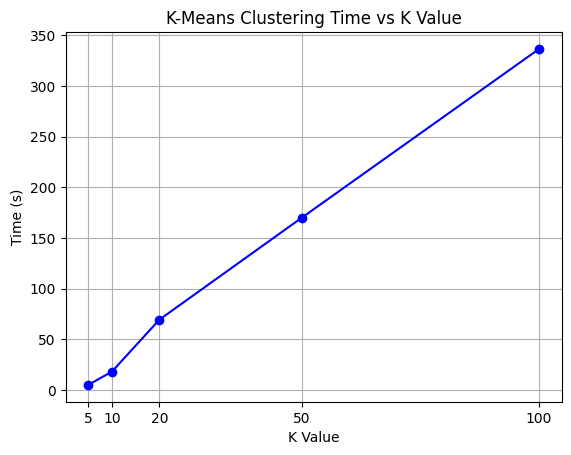

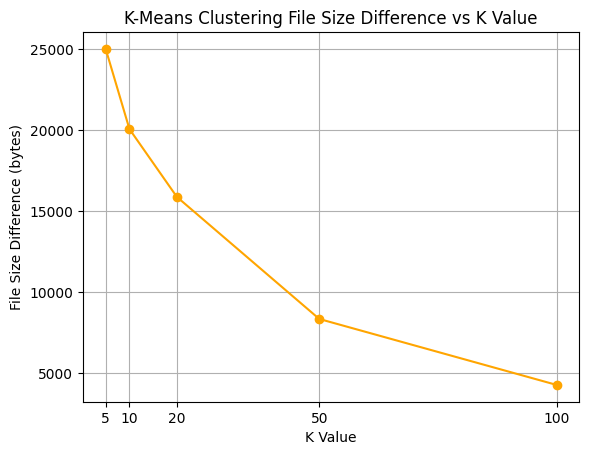

In [ ]:
'''
K MEANS MODEL

This block will build a k-means clustering model on a given dataset.
'''

# Creation of model class for k means image compression
class KMeansImageCompression:

	# Class Constructor
	def __init__(self, fileName, fileNameOut="test_image_out.png", k=10, maxIterations=100):
		self.fileName = fileName
		self.fileNameOut = fileNameOut
		self.k = k
		self.maxIterations = maxIterations
		self.clusters = []

		#########################################################
		# CODE PROVIDED BY DR. AAKUR IN ASSIGNMENT INSTRUCTIONS #
		#########################################################
		self.img = cv2.imread(self.fileName) # Edit by CH: Get file name from func parameter, save to class
		self.height, self.width, self.channels = np.shape(self.img) # Edit by CH: Saving to class
		#############################################################
		# END CODE PROVIDED BY DR. AAKUR IN ASSIGNMENT INSTRUCTIONS #
		#############################################################

		if DFLAG_PRINT_KMEANSINFO:
			print(f"Beginning K-Means Image Compression with {self.k} clusters and {self.maxIterations} max iterations.")
			print(f"Image dimensions: w={self.width}, h={self.height} with {self.channels} channels.")

		# K-Means Cluster Initialization
		for i in range(self.k):
			# Randomly select a pixel for initializing the cluster center
			randomX = np.random.randint(0, self.width)
			randomY = np.random.randint(0, self.height)

			# Get pixel value at random location
			pixelValue = self.img[randomY][randomX]

			# Append the value to the clusters list (value is np.ndarray, looks like [B, R, G])
			self.clusters.append(pixelValue)

		# K-Means Iteration
		for iteration in range(self.maxIterations):
			# Initialize list for new clusters
			newClusters = []

			# Initialize the clustered dictionary for this iteration
			iterationClusteredDict = {}
			for i in range(self.k):
				iterationClusteredDict[i] = []

			# Add each pixel value to the nearest cluster
			for i in range(self.width):
				for j in range(self.height):
					iterationClusteredDict[self.__getNearestCluster(i, j)].append(self.img[j][i])

			# Iterate over clusters to find means
			for clusterIteration in range(self.k):
				# Get the list of pixel values assigned to this cluster
				clusterPixels = np.array(iterationClusteredDict[clusterIteration])

				# Get mean for each channel and append to new clusters
				newClusters.append(np.mean(clusterPixels, axis=0))

			# Check for convergence
			if self.__checkIfConverged(self.clusters, newClusters):
				if DFLAG_PRINT_KMEANSINFO:
					print(f"K-Means has converged after {iteration + 1} iterations.")
				break

			elif (iteration + 1) == self.maxIterations:
				if DFLAG_PRINT_KMEANSINFO:
					print(f"K-Means has reached the maximum number of iterations ({self.maxIterations}) without convergence.")

			# Update clusters with new means
			self.clusters = newClusters

		# Assign each pixel to the nearest cluster
		for i in range(self.width):
			for j in range(self.height):
				# Get the nearest cluster for the pixel
				nearestClusterIndex = self.__getNearestCluster(i, j)

				# Set the pixel value to the cluster value
				self.img[j][i] = self.clusters[nearestClusterIndex]

		if DFLAG_PRINT_KMEANSINFO:
			print(f"K-Means Image Compression has completed! Check for output file '{self.fileNameOut}'!")

		# Save the compressed image
		cv2.imwrite(self.fileNameOut, self.img)

	# Get the nearest cluster for a given pixel (i, j)
	def __getNearestCluster(self, i, j):
		minDifference = None
		nearestClusterIndex = 0
		pixelValue = self.img[j][i]

		# Iterate over clusters to find the closest
		for clusterIteration in range(self.k):
			# Calculate the difference between the pixel value and cluster value (Euclidean for color values)
			clusterValue = self.clusters[clusterIteration]
			colorDifference = np.abs(np.linalg.norm(pixelValue - clusterValue))

			# Update the nearest cluster if this one is closer
			if (minDifference is None) or (colorDifference < minDifference):
				minDifference = colorDifference
				nearestClusterIndex = clusterIteration

		# Return index of nearest cluster
		return nearestClusterIndex

	# Check if the clusters have converged
	def __checkIfConverged(self, oldClusters, newClusters, tolerance=1e-3):
		for i in range(len(oldClusters)):
			oldClusterValue = oldClusters[i]
			newClusterValue = newClusters[i]

			# Check if the coordinates or values have changed significantly
			if (np.abs(np.linalg.norm(oldClusterValue - newClusterValue)) > tolerance):
				# If any cluster has changed significantly, return False
				return False
		return True

##################
# ALGORITHM RUNS #
##################
kMeansTimer.startTimer("K5")
KMeansImageCompression("test_image.png", "test_image_out_k5.png", 5)
kMeansTimer.endTimer("K5")
kMeansFileSize.recordFileSizeDiff("K5", "test_image.png", "test_image_out_k5.png")

kMeansTimer.startTimer("K10")
KMeansImageCompression("test_image.png", "test_image_out_k10.png", 10)
kMeansTimer.endTimer("K10")
kMeansFileSize.recordFileSizeDiff("K10", "test_image.png", "test_image_out_k10.png")

kMeansTimer.startTimer("K20")
KMeansImageCompression("test_image.png", "test_image_out_k20.png", 20)
kMeansTimer.endTimer("K20")
kMeansFileSize.recordFileSizeDiff("K20", "test_image.png", "test_image_out_k20.png")

kMeansTimer.startTimer("K50")
KMeansImageCompression("test_image.png", "test_image_out_k50.png", 50)
kMeansTimer.endTimer("K50")
kMeansFileSize.recordFileSizeDiff("K50", "test_image.png", "test_image_out_k50.png")

kMeansTimer.startTimer("K100")
KMeansImageCompression("test_image.png", "test_image_out_k100.png", 100)
kMeansTimer.endTimer("K100")
kMeansFileSize.recordFileSizeDiff("K100", "test_image.png", "test_image_out_k100.png")

###################
# RESULTS DISPLAY #
###################
# Display results for K-Means model
KResults_header = ["K Value", "Time (s)", "File Size Difference (bytes)"]
KMeansResults_Table = []
KMeansResults_Table.append(["5", kMeansTimer.getDuration("K5"), kMeansFileSize.getFileSizeDiff("K5")])
KMeansResults_Table.append(["10", kMeansTimer.getDuration("K10"), kMeansFileSize.getFileSizeDiff("K10")])
KMeansResults_Table.append(["20", kMeansTimer.getDuration("K20"), kMeansFileSize.getFileSizeDiff("K20")])
KMeansResults_Table.append(["50", kMeansTimer.getDuration("K50"), kMeansFileSize.getFileSizeDiff("K50")])
KMeansResults_Table.append(["100", kMeansTimer.getDuration("K100"), kMeansFileSize.getFileSizeDiff("K100")])

# Display the results table
print(tabulate.tabulate(KMeansResults_Table, headers=KResults_header, tablefmt='github'))

# Plot time vs k value
k_values = [5, 10, 20, 50, 100]
k_times = [kMeansTimer.getDuration("K5"), kMeansTimer.getDuration("K10"), kMeansTimer.getDuration("K20"), kMeansTimer.getDuration("K50"), kMeansTimer.getDuration("K100")]
plt.plot(k_values, k_times, marker='o', color='blue')
plt.xlabel('K Value')
plt.ylabel('Time (s)')
plt.title('K-Means Clustering Time vs K Value')
plt.xticks(k_values)
plt.grid()
plt.show()

# Plot file size difference vs k value
k_file_sizes = [kMeansFileSize.getFileSizeDiff("K5"), kMeansFileSize.getFileSizeDiff("K10"), kMeansFileSize.getFileSizeDiff("K20"), kMeansFileSize.getFileSizeDiff("K50"), kMeansFileSize.getFileSizeDiff("K100")]
plt.plot(k_values, k_file_sizes, marker='o', color='orange')
plt.xlabel('K Value')
plt.ylabel('File Size Difference (bytes)')
plt.title('K-Means Clustering File Size Difference vs K Value')
plt.xticks(k_values)
plt.grid()
plt.show()
